In [ ]:
!pip install pennylane

**Introduction to Applications of Quantum Computing to Quantum Chemistry**

**Problem 2: challenge**

**Item (a)**

In this notebook, following the lecture notebook, we implement a variational quantum eigensolver (VQE) to estimate the ground state energy of the H2 moleculle. The first cell loads the necessary libraries, the second one constructs the function 'VQE_H2', which takes as input only an array of positions, localizing the hidrogen nuclei. This function returns the energy of the ground state of H2 after a given accuracy is reached, and also plots the evolution of the cost function (ground state energy) and the optimization parameters.

A few auxiliary lines are commented, but can help to illustrate the proposed solution. For instance, visualizing some estimated values for the cost function.

In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt

In [ ]:
def VQE_H2(positions):

  atoms_name = ['H', 'H']
  nuclear_positions = positions

  # Create the molecule specifying the atoms, their positions, net charge, multiplicity and the basis set to represent the orbitals
  molecule = qml.qchem.Molecule(atoms_name, nuclear_positions, charge = 0, mult = 1, basis_name = 'sto-3g')

  # from the molecule, use the Jordan-Wigner mapping to obtain the hamiltonian in terms of Pauli operators, as well as the number of qubits
  mol_hamiltonian, qubits = qml.qchem.molecular_hamiltonian(molecule, mapping='jordan_wigner')

  # Initial state: Hartree-Fock (hf_state)
  electrons = 2
  orbitals = qubits
  hf_state = qml.qchem.hf_state(electrons,orbitals)

  # Define the base structure for the VQE circuit
  def base_circuit_VQE(param, wires):
    # prepare the initial Hartree-Fock state using 'qml.BasisState'
    qml.BasisState(hf_state, wires = wires)
    # generate double excitations
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])


  # Create a quantum device that will run the VQE circuit
  dev = qml.device("default.qubit", wires = qubits)
  @qml.qnode(dev)
  # define cost function (expected value of molecular hamiltonian)
  def cost(param):
      base_circuit_VQE(param, wires = range(qubits))
      return qml.expval(mol_hamiltonian)

  # choose the optimizer and a step size
  opt = qml.GradientDescentOptimizer(stepsize = 0.05)

  # set initial guess (parameter to be optimized)
  theta = pnp.array(2.0, requires_grad=True)

  # open lists to store energies and parameters
  energies = [cost(theta)]
  parameters = [theta]

  # set a maximum number of iterations and a convergence criterion: when the difference between estimated energies is less than 'convergence', the algorithm stops
  iterations = 200
  convergence = 0.0001

  # open lists for plotting the results
  plot_x = []
  plot_y  = []
  plot_theta = []

  # loop over the number of iteratation steps
  for n in range(iterations):
      theta, prev_energy = opt.step_and_cost(cost, theta)

      energies.append(cost(theta))
      parameters.append(theta)
      conv = pnp.abs(energies[-1] - prev_energy)

      if n % 10 == 0:

        ## uncomment if you wish the function to print some energy values!
        # print(f"Iteration = {n},  Energy = {energies[-1]}")
        plot_x.append(n)
        plot_y.append(cost(theta))
        plot_theta.append(theta)

      if conv <= convergence:
          break

  # plot the results
  fig = plt.figure()
  fig.set_figheight(5)
  fig.set_figwidth(12)

  # Add energy plot on column 1
  ax1 = fig.add_subplot(121)
  ax1.plot(plot_x, plot_y, '-o')
  ax1.set_xlabel('Iteration')
  ax1.set_ylabel('Cost function')

  # Add angle plot on column 2
  ax2 = fig.add_subplot(122)
  ax2.plot(plot_x, plot_theta, 'o-')
  ax2.set_xlabel('Iteration')
  ax2.set_ylabel("$\\theta$ (rad)")

  plt.show()

  return energies[-1]

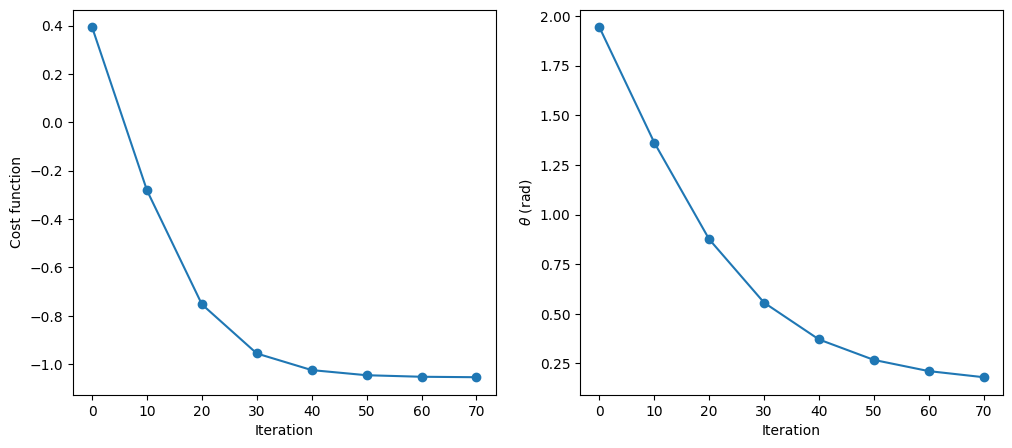

The ground state energy is: -1.053737002964182


In [ ]:
# set array with positions
positions = pnp.array([-0.1, 0.1, 0.1, 0.5, 0.8, 0.3])

# call the function
ground_energy = VQE_H2(positions)

print('The ground state energy is: {}'.format(ground_energy))